<a href="https://colab.research.google.com/github/Madfury0/Person-Car-Detection/blob/main/RGB_custom_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data preprocessing

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import time
from datetime import datetime

t = datetime.now().strftime("%H:%M")

model_name = 'RGB'

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in Google Drive
data_path = '/content/drive/MyDrive/dataset'
os.makedirs(data_path, exist_ok=True)
print(f"Folder '{data_path}' created in Google Drive.")

save_directory = '/content/drive/MyDrive/models'
os.makedirs(save_directory, exist_ok=True)
save_path = os.path.join (save_directory, f"{model_name}.keras")


save_directory = '/content/drive/MyDrive/models'
os.makedirs(save_directory, exist_ok=True)
save_path_lite = os.path.join (save_directory, f"{model_name}.tflite")


Test_dir = '/content/drive/MyDrive/Test_img'
os.makedirs(Test_dir, exist_ok=True)
Test_folder= '/content/drive/MyDrive/Test_img/test'
os.makedirs(Test_folder, exist_ok=True)

Ard_dir = '/content/drive/MyDrive/Arduino'
os.makedirs(Ard_dir, exist_ok=True)
Lib_folder= '/content/drive/MyDrive/Arduino/Library'
os.makedirs(Lib_folder, exist_ok=True)

Mounted at /content/drive
Folder '/content/drive/MyDrive/dataset' created in Google Drive.


In [ ]:

DATADIR = data_path
CATEGORIES = ['person','car']

IMG_SIZE = 96

training_data = []

def create_training_data ():
    for category in CATEGORIES:
        path = os.path.join (DATADIR, category)
        class_num = CATEGORIES.index (category)
        for img in os.listdir (path):
            try:
                img_array = cv2.imread (os.path.join(path, img))
                img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
                new_array = cv2.resize (img_array, (IMG_SIZE, IMG_SIZE))
                new_array = new_array/255
                training_data.append ([new_array, class_num])
            except Exception as e:
                pass
    return class_num

create_training_data ()

In [ ]:

save_directory ='/content/drive/MyDrive/Training_data'
os.makedirs(save_directory, exist_ok=True)
class_path = os.path.join (save_directory, "class_num.txt")

with open(class_path, 'w') as file:
    file.write(str(class_num))

In [ ]:


import random
for i in range (3):
    random.shuffle (training_data)

In [ ]:
print (len(training_data))
for sample in training_data[:20]:
   print (sample[1] )

In [ ]:
from tensorflow.keras.utils import to_categorical
X = []
y = []
for features, label in training_data:
    X.append (features)
    y.append (label)
X = np.array (X).reshape (-1,IMG_SIZE,IMG_SIZE,3)
y = np.array (y)
count_zeros = np.count_nonzero(y == 0)
print (count_zeros)
y = to_categorical(y, num_classes=2)

Data saving

In [ ]:
#saving training data
import pickle
save_directory ='/content/drive/MyDrive/Training_data'
os.makedirs(save_directory, exist_ok=True)
save_path_X = os.path.join (save_directory, f"X-{model_name}.pickle")
save_path_y = os.path.join (save_directory, f"y-{model_name}.pickle")

pickle_out = open (save_path_X, "wb")
pickle.dump (X, pickle_out)
pickle_out.close ()

pickle_out = open (save_path_y, "wb")
pickle.dump (y, pickle_out)
pickle_out.close ()

In [ ]:

#loading training data
import pickle
save_directory ='/content/drive/MyDrive/Training_data'
os.makedirs(save_directory, exist_ok=True)
save_path_X = os.path.join (save_directory, f"X-{model_name}.pickle")
save_path_y = os.path.join (save_directory, f"y-{model_name}.pickle")


pickle_in = open (save_path_X, "rb")
X = pickle.load (pickle_in)

pickle_in = open (save_path_y, "rb")
y = pickle.load (pickle_in)

In [ ]:
print (X.shape)
print (y.shape)
print (y[10:])

Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

CNN model

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

l_r = 0.0005
Epochs = 15
opt = Adam(learning_rate = l_r)
batch_size = 32

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model = Sequential()

model.add(Conv2D(128, (3, 3), input_shape=X.shape[1:],kernel_regularizer=regularizers.l1(0.01)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(2))
model.add(Activation ("softmax"))


model.compile(loss = "binary_crossentropy",
              optimizer = opt,
              metrics = ["accuracy"])

datagen.fit(X_train)

train_generator = datagen.flow(X_train, y_train, batch_size = batch_size)

#print(type(train_generator))

history = model.fit(train_generator, steps_per_epoch=len(X_train) // batch_size, epochs=Epochs, validation_data=(X_val, y_val))

#checkpoint = ModelCheckpoint(save_path,save_freq = 'epoch', monitor='val_loss', save_best_only=True, save_weights_only=False, mode='auto')
#history = model.fit(X,y, batch_size = 32, epochs = Epochs, verbose = 1, callbacks = [checkpoint])

Epoch 1/15
225/225 [==============================] - 29s 98ms/step - loss: 1.0277 - accuracy: 0.5921 - val_loss: 0.6674 - val_accuracy: 0.6670
Epoch 2/15
225/225 [==============================] - 32s 143ms/step - loss: 0.5912 - accuracy: 0.7446 - val_loss: 0.5216 - val_accuracy: 0.8130
Epoch 3/15
225/225 [==============================] - 22s 96ms/step - loss: 0.5215 - accuracy: 0.7837 - val_loss: 0.4859 - val_accuracy: 0.8257
Epoch 4/15
225/225 [==============================] - 22s 96ms/step - loss: 0.4819 - accuracy: 0.8017 - val_loss: 0.4332 - val_accuracy: 0.8563
Epoch 5/15
225/225 [==============================] - 20s 90ms/step - loss: 0.4499 - accuracy: 0.8205 - val_loss: 0.4062 - val_accuracy: 0.8563
Epoch 6/15
225/225 [==============================] - 21s 94ms/step - loss: 0.4138 - accuracy: 0.8432 - val_loss: 0.3542 - val_accuracy: 0.8824
Epoch 7/15
225/225 [==============================] - 22s 98ms/step - loss: 0.4011 - accuracy: 0.8460 - val_loss: 0.4120 - val_accuracy

In [ ]:
model.summary ()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 128)       3584      
                                                                 
 activation (Activation)     (None, 94, 94, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 47, 47, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 45, 45, 64)        0         
                                                        

In [ ]:
model.evaluate(X_val,y_val)

57/57 [==============================] - 1s 9ms/step - loss: 0.2790 - accuracy: 0.9068


[0.279009610414505, 0.9067702293395996]

In [ ]:
model.save(save_path)

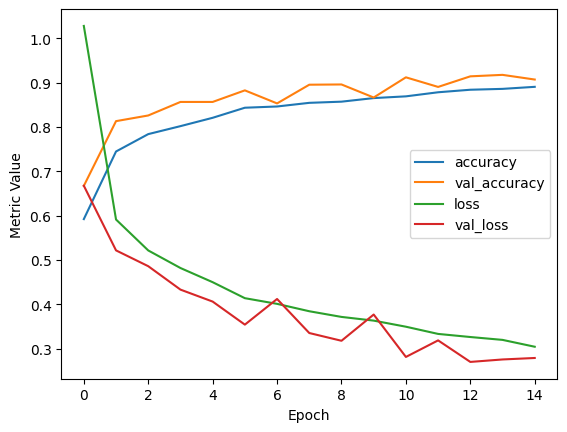

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

Random images test

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model(save_path)

print(f"Model loaded successfully: {model}")

Model loaded successfully: <keras.src.engine.sequential.Sequential object at 0x7821fe2ff490>


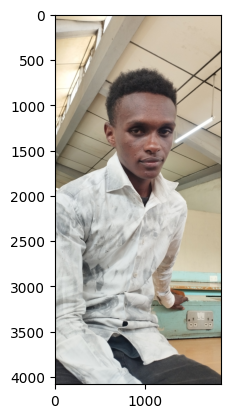

1/1 [==============================] - 0s 66ms/step
person 0.81767917


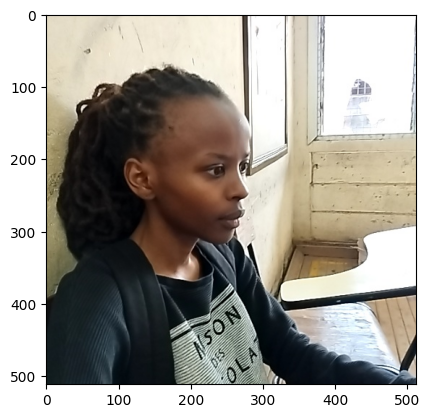

1/1 [==============================] - 0s 28ms/step
person 0.99825174


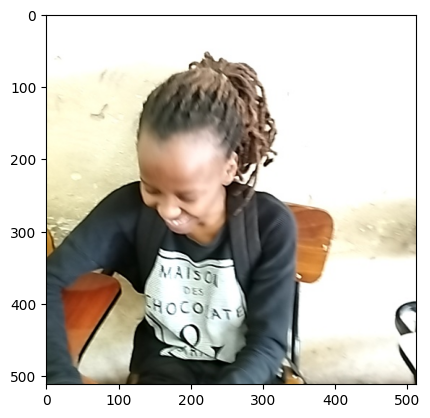

1/1 [==============================] - 0s 17ms/step
person 0.99910116


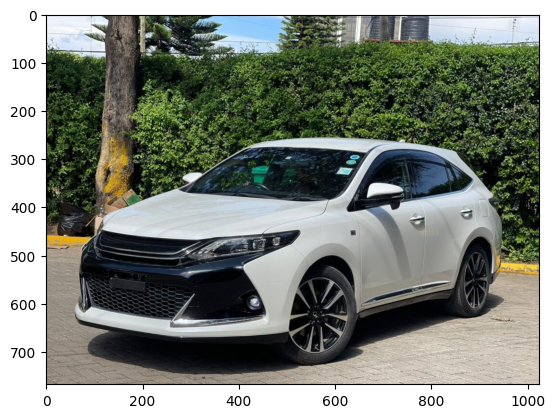

1/1 [==============================] - 0s 30ms/step
car 0.99999034


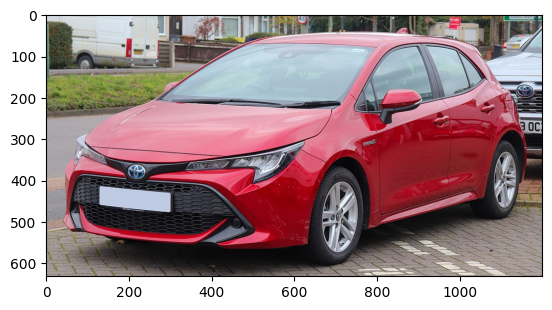

1/1 [==============================] - 0s 25ms/step
car 0.9999138


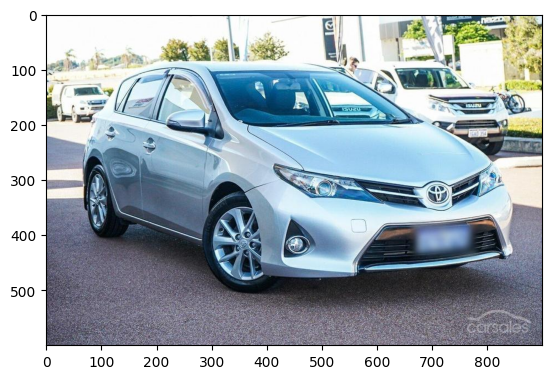

1/1 [==============================] - 0s 25ms/step
car 0.9999273


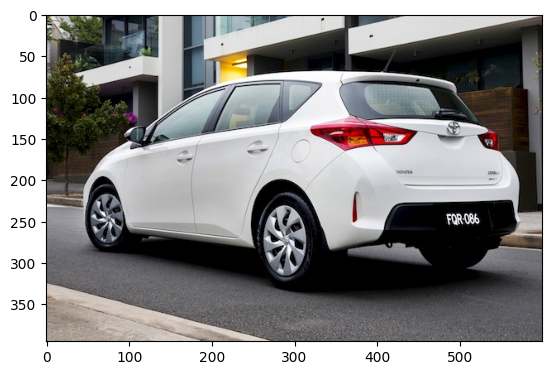

1/1 [==============================] - 0s 40ms/step
car 1.0


In [ ]:

directory_path = Test_dir
folder_name = Test_folder
test_folder_path = os.path.join(directory_path, folder_name)

IMG_SIZE = 96
DATADIR = data_path
CATEGORIES = ['person','car']


if os.path.exists(test_folder_path):
    image_files = [f for f in os.listdir(test_folder_path) if os.path.isfile(os.path.join(test_folder_path, f))]
    for image_file in image_files:
        image_path = os.path.join(test_folder_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow (img)
        plt.show ()
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        img = img/255
        input_img = np.expand_dims(img, axis=0)
        Predictions = model.predict([input_img])

        predicted_class = CATEGORIES[np.argmax(Predictions)]
        confidence = np.max(Predictions)


        if  confidence >= 0.6:
            print (predicted_class, confidence)
        else:
            print ("unrecognisable class")
else:
    print(f"The folder '{folder_name}' doesn't exist")

Using opencv for real time inferencing

In [ ]:

# Define the categories and confidence threshold
CATEGORIES = ['person', 'car']
CONFIDENCE_THRESHOLD = 0.7

# Load the pre-trained model
model = model

# Start video capture from the default camera (index 0)
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Perform object detection on the frame
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255
    input_img = np.expand_dims(img, axis=0)
    predictions = model.predict([input_img])

    predicted_class = CATEGORIES[np.argmax(predictions)]
    confidence = np.max(predictions)

    # Display the frame with object detection results
    cv2.putText(frame, f'{predicted_class}: {confidence}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow('Object Detection', frame)

    # Exit loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


Converting to tflite

In [ ]:
import tensorflow as tf
IMG_SIZE = 96

DATADIR = data_path
CATEGORIES = ['person', 'car']

def representative_data_gen():
    data_dir = DATADIR
    batch_size = 32
    img_height = IMG_SIZE
    img_width = IMG_SIZE

    class_names = CATEGORIES

    train_images = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        class_names=class_names,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)

    #standardize the images
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)
    normalized_ds = train_images.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next((iter(normalized_ds)))
    first_image = image_batch[0]
    #print(image_batch)
    # Notice the pixels values are now in `[0,1]`.
    print(np.min(first_image), np.max(first_image))

    for input_value in tf.data.Dataset.from_tensor_slices(image_batch).batch(1).take(100):
        # Model has only one input so each data point has one element.
        yield [input_value]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_quant_model = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Found 9010 files belonging to 2 classes.
Using 7208 files for training.
0.0 0.9790851


In [ ]:
with open(save_path_lite, "wb") as f:
    f.write(tflite_quant_model)

In [ ]:
interpreter = tf.lite.Interpreter(save_path_lite)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

Input details: [{'name': 'serving_default_conv2d_4_input:0', 'index': 0, 'shape': array([ 1, 96, 96,  3], dtype=int32), 'shape_signature': array([-1, 96, 96,  3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 19, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
summary = interpreter.get_signature_list()
print("Model Summary:", summary)

Model Summary: {'serving_default': {'inputs': ['conv2d_4_input'], 'outputs': ['activation_11']}}


In [ ]:
input_tensor_shape = input_details[0]['shape']
output_tensor_shape = output_details[0]['shape']
input_tensor_type = input_details[0]['dtype']
output_tensor_type = output_details[0]['dtype']

print("Input Tensor Shape:", input_tensor_shape)
print("Output Tensor Shape:", output_tensor_shape)
print("Input Tensor Type:", input_tensor_type)
print("Output Tensor Type:", output_tensor_type)

Input Tensor Shape: [ 1 96 96  3]
Output Tensor Shape: [1 2]
Input Tensor Type: <class 'numpy.uint8'>
Output Tensor Type: <class 'numpy.uint8'>


Model deployment

In [ ]:
!pip install edgeimpulse

In [ ]:
import edgeimpulse as ei

ei.API_KEY = "ei_1cf0b46f84d9b28ccf08db95d6bc0ea6131e1a3af90487d7a8a97aaab0dc330e"

In [ ]:
ei.model.list_profile_devices()

In [ ]:
profile = ei.model.profile(model=tflite_quant_model, device='espressif-esp32')
print(profile.summary())

In [ ]:
#print(f"Estimated RAM usage: {profile.model.profile_info.float32.memory.tflite.ram}")
#print(f"Estimated ROM usage: {profile.model.profile_info.float32.memory.tflite.rom}")
#print(f"Estimated inference time (ms): {profile.model.profile_info.float32.time_per_inference_ms}")

In [ ]:
ei.model.list_deployment_targets()

In [ ]:
ei.model.deploy(model=tflite_quant_model,
                model_input_type=ei.model.input_type.OtherInput(),
                model_output_type=ei.model.output_type.Classification(),
                output_directory=Lib_folder)